# Escalonando a Análise de Dados com Expressões Ibis

![Ibis](../../../images/blog/ibis-escalonando-sua-analise-de-dados/ibis-bird.jpg)

[Ibis Framework](https://github.com/ibis-project/ibis/) é uma biblioteca Python que gera expressões de busca em banco de dados. O framework foi idealizado por [Wes McKinney](https://github.com/wesm), o mesmo criador do Pandas, voltado para integração de diferentes Engines de Bancos de Dados através de Expressões Ibis com Python. 

Enquanto os motores de busca e análise de dados crescem e ficam mais robustos com o avanço da era dos Dados, algumas complicações podem ser encontradas em diferentes ambientes de desenvolvimento. Um dos exemplos mais comuns é o crescimento de aplicações que realizam buscas SQL em um banco de dados, com o tempo as buscas se tornam complexas e de difícil leitura.

Atualmente o Ibis possui 12 backends em seu escopo, alguns deles são responsáveis pela manipulação dos dados, outros, como por exemplo o SQLAlchemy, são responsáveis pela tradução das expressões Ibis em buscas SQL, etc. Você pode conferir todos os backends [aqui](https://ibis-project.org/docs/3.1.0/backends/).

<!-- TEASER_END -->

## Setup e Base de Dados

O Ibis pode ser instalado via `pip` ou `conda`. Nos exemplos a seguir utilizaremos apenas a instalação padrão do Ibis, mas você pode conferir como instalar outros Backends como o [Google BigQuery](https://github.com/ibis-project/ibis-bigquery/), [Apache Impala](https://github.com/ibis-project/ibis-bigquery/), [PostgreSQL](https://ibis-project.org/docs/3.1.0/backends/PostgreSQL/) dependendo da sua necessidade.

In [ ]:
!mamba install ibis-framework matplotlib sqlalchemy -c conda-forge -y

Estaremos trabalhando com um dataset disponibilizado pelo Ministério da Saúde em formato CSV.

In [14]:
!wget -c https://data.brasil.io/dataset/covid19/caso_full.csv.gz && gunzip -c caso_full.csv.gz > data/caso_full.csv

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import ibis

## Como funciona o Ibis?

O Ibis, a partir da criação de Expressões, se consitui em uma camada de abstração entre as Engines de banco de dados e o usuário final. Em seu backend, o Ibis utiliza Pandas como sua Engine de execução, então podemos ler o arquivo CSV com a função `read_csv()` do Pandas:

In [15]:
df = ibis.backends.pandas.pd.read_csv('data/caso_full.csv')

In [16]:
df.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0,0,1,city,AC,3,0
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0,0,1,state,AC,3,0
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0,0,2,city,AC,0,0
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0,0,2,state,AC,0,0
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0,0,3,city,AC,1,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3853648 entries, 0 to 3853647
Data columns (total 18 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   city                                           object 
 1   city_ibge_code                                 float64
 2   date                                           object 
 3   epidemiological_week                           int64  
 4   estimated_population                           float64
 5   estimated_population_2019                      float64
 6   is_last                                        bool   
 7   is_repeated                                    bool   
 8   last_available_confirmed                       int64  
 9   last_available_confirmed_per_100k_inhabitants  float64
 10  last_available_date                            object 
 11  last_available_death_rate                      float64
 12  last_available_deaths                     

E para demonstrar o verdadeiro poder do Ibis, iremos transformar nosso arquivo CSV em uma Base de Dados SQL. Na instalação padrão do Ibis, o backend SQL é o `sqlite3`, então nos exemplos a seguir utilizaremos SQLite para realizar buscas na base de dados. Caso queira utilizar outra Engine SQL, como [BigQuery](https://github.com/ibis-project/ibis-bigquery/) ou [Postgres](https://ibis-project.org/docs/3.1.0/backends/PostgreSQL/), acesse a [documentação oficial](https://ibis-project.org/docs/3.1.0/backends/PostgreSQL/) e siga instruções de instalação.

In [18]:
df.to_sql('casos_covid19_BR', sqlite3.connect('data/casof.db'))

3853648

In [19]:
con = ibis.sqlite.connect('data/casof.db')
casos = con.table('casos_covid19_BR')

O Ibis, junto com o SQLAlchemy, utiliza grafos para representar suas Expressões. Portanto é possível visualizar todas as etapas ocorridas no Backend com a configuração de representação de grafos ativa. Da mesma forma, podemos representar o Schema da nossa tabela através da função `display()`:

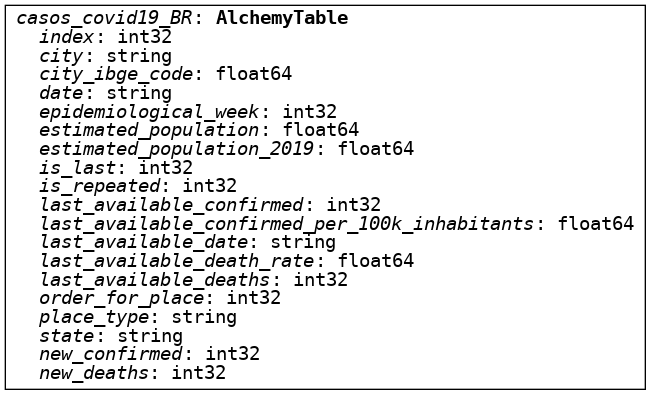

In [20]:
ibis.options.graphviz_repr = True
display(casos)

Assim como no Pandas, as colunas podem ser chamadas diretamente. Entretanto, como o Ibis funciona por padrão em [`Lazy mode`](https://ibis-project.org/docs/3.1.0/tutorial/03-Expressions-Lazy-Mode-Logging/?h=lazy), o resultado da query não fica armazenado em memória e ela só será executada utilizando o comando `execute()`. O lazy mode busca diminuir a utilização da memória, ao invés de executar a busca quando o objeto é instanciado, o Ibis retorna uma expressão contendo os parâmetros de busca, executando a busca somente quando necessário:

In [21]:
# Semelhante ao pandas, podemos realizar uma busca SQL que retorna os valores max. e min. da coluna
data_min = casos.date.min().name('first_entry')
data_max = casos.date.max().name('last_entry')

In [22]:
print(data_min.execute()) # Dia da primeira entrada registrada na base de dados
print(data_max.execute()) # Dia da última entrada registrada na base de dados

2020-02-25
2022-03-27


## E por que usar Ibis ao invés das ferramentas SQL diretamente?


- Ibis, por ser uma ferramenta escrita em Python, é atraente para quem não tem tanta familiaridade com SQL. Ao automatizar as buscas, novos desenvolvedores poderão entender como as buscas são feitas na Engine SQL.
- Com o crescimento da aplicação, os parâmetros de busca em SQL podem se tornar confusos e de difícil replicação. Com o Ibis é possível portabilizar as Expressões para serem reutilizadas em outras buscas sem a necessidade de reescrever código.
- Caso você esteja trabalhando com diferentes Engines SQL, seja por causa do tamanho da base de dados, por exemplo. Com o Ibis é possível rapidamente conectar à uma Engine que consiga lidar diferentes volumes de dados ([ClickHouse](https://ibis-project.org/docs/3.1.0/backends/ClickHouse/), [HeavyAI](https://github.com/heavyai/ibis-heavyai), etc) e continuar com o mesmo fluxo de trabalho.

Por exemplo: já vimos que é possível criar buscas SQL através de expressões Ibis, entretanto, o oposto também pode ser visualizado. Com a função `compile()` podemos retornar os parâmetros da busca realizada pela Expressão Ibis na base de dados. Ou seja, é possível realizar análises das buscas na base de dados com facilidade, pois o Ibis te mostra como fez para retornar o resultado desejado:

In [23]:
print(data_min.compile())

SELECT min(t0.date) AS first_entry 
FROM main."casos_covid19_BR" AS t0


Um dos pontos chave do Ibis, é a possibilidade de criar Expressões com o resultado de interesse, renomeá-las, e utilizá-las para outras buscas sem precisar repetir código:

In [24]:
total_new_cases = casos['new_confirmed'].sum().name('total_new_cases')
total_new_deaths = casos['new_deaths'].sum().name('total_new_deaths')

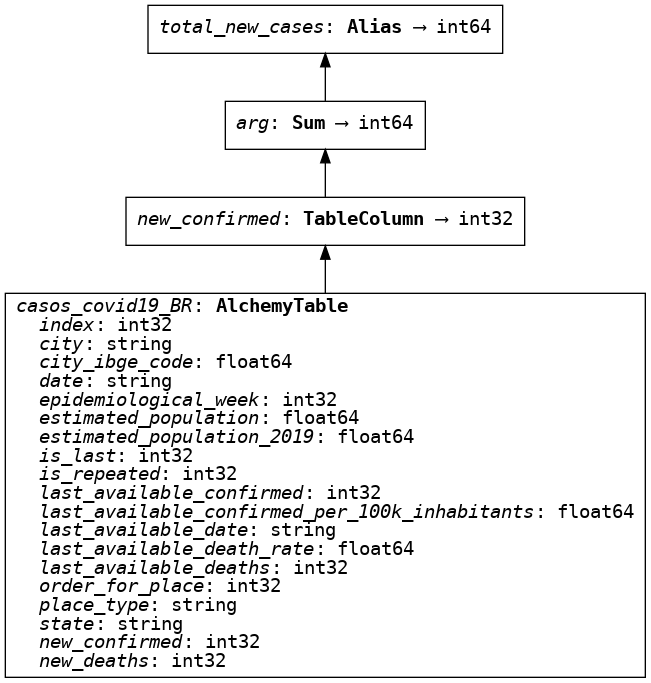

In [25]:
total_new_cases

In [26]:
epiweek_covid = casos.group_by('epidemiological_week').aggregate((
                                                                    total_new_cases, 
                                                                    total_new_deaths,
                                                                    ))

print(epiweek_covid.compile())

SELECT t0.epidemiological_week, sum(t0.new_confirmed) AS total_new_cases, sum(t0.new_deaths) AS total_new_deaths 
FROM main."casos_covid19_BR" AS t0 GROUP BY t0.epidemiological_week


Lembra que o Ibis utiliza o Pandas como Backend de execução? Podemos agora salvar o Pandas DataFrame gerado na execução em uma variável para termos acesso às funções do Pandas:

In [27]:
df = epiweek_covid.execute()
df.head()

,epidemiological_week,total_new_cases,total_new_deaths
0,202009,4,0
1,202010,33,0
2,202011,231,0
3,202012,1935,30
4,202013,5476,183


In [28]:
df['week'] = df['epidemiological_week'].astype(str).str[4:6]
df['year'] = df['epidemiological_week'].astype(str).str[0:4]

df.pop('epidemiological_week')
df.insert(0, 'year', df.pop('year'))
df.insert(1, 'week', df.pop('week'))
df.head()

,year,week,total_new_cases,total_new_deaths
0,2020,09,4,0
1,2020,10,33,0
2,2020,11,231,0
3,2020,12,1935,30
4,2020,13,5476,183


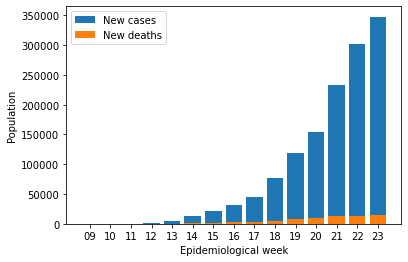

In [29]:
df = df.head(15)
plt.bar(df.week, df.total_new_cases)
plt.bar(df.week, df.total_new_deaths)
plt.xlabel('Epidemiological week')
plt.ylabel('Population')
plt.legend(['New cases', 'New deaths'])
plt.show()

## Manipulando os dados e inserindo novas colunas:

Os DataFrames gerados pelo Pandas Engine são estáticos. Isso quer dizer que ao manipular os dados, as expressões não alteram o DataFrame em si, mas preparam os parâmetros de busca para gerar um novo DataFrame a partir do comando `execute()`, que pode ser visualizado, armazenado e exportado.

No exemplo abaixo, estaremos parametrizando a busca a ser realizada na base de dados. Com uma sintaxe "Pandas-like", pode-se imaginar que estaremos manipulando o DataFrame em si. Entretanto, o Ibis armazena o resultado desejado para que a busca seja realizada somente quando o resultado deve ser exibido, executando-o. Ao extrair as colunas como em `percentage_cases`, por exemplo, uma query SQL é armazenada

Operações matemáticas entre as colunas podem ser escritas de maneira Pythonica com o Ibis e facilmente adicionadas em outros critérios de busca:

In [69]:
percentage_cases = (casos['new_confirmed'] / casos['estimated_population'] * 100).name('porc_cases')

Assim como em SQL, `when clauses` podem ser usadas para extrair apenas certas partes dos dados. Neste exemplo estaremos extraindo as informações dos estados do Sul do país, para que no final seja retornado um DataFrame com os parâmetros definidos. Com o modo de gráficos ativo, podemos visualizar os passos armazenados nos parâmetros de busca:

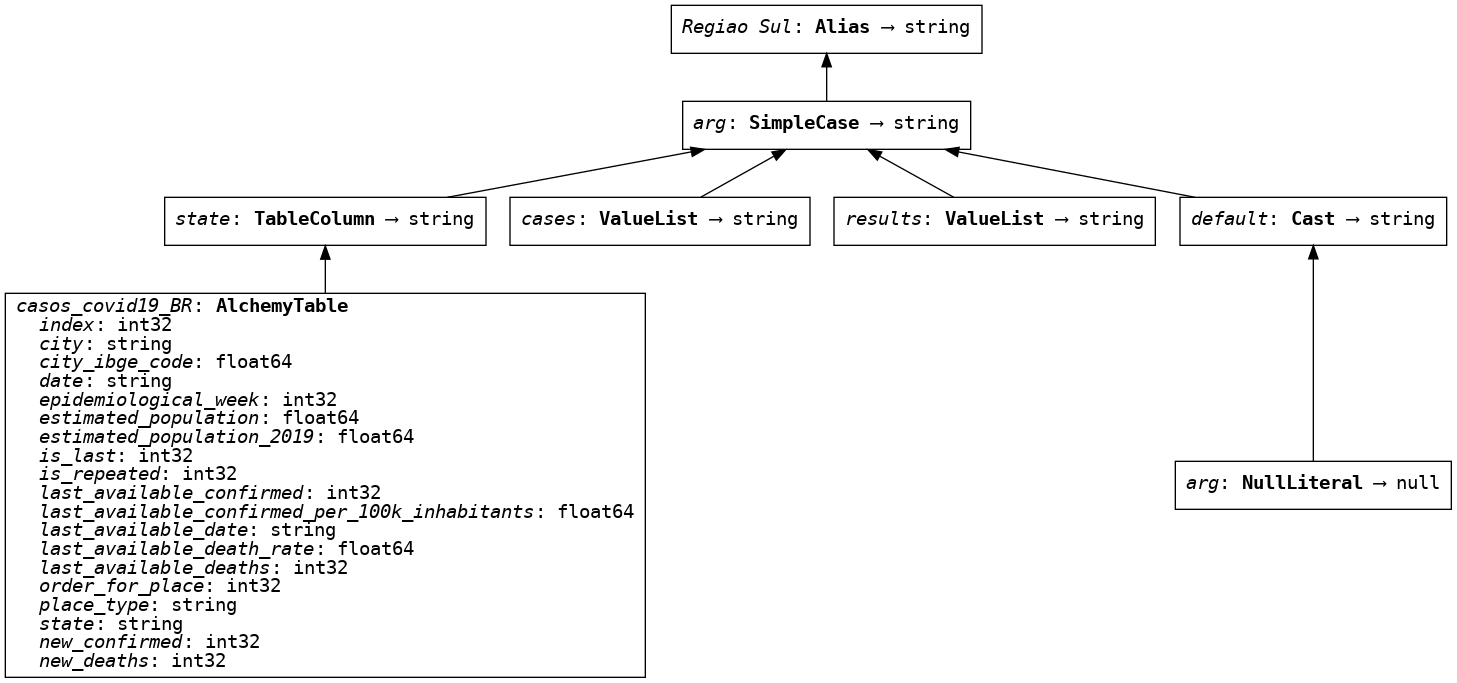

In [70]:
south_br = (casos.state.case()
          .when('SC', 'Santa Catarina')
          .when('RS', 'Rio Grande do Sul')
          .when('PR', 'Parana')
          .end()
          .name('Regiao Sul'))

south_br

Compilando as buscas com os parâmetros, podemos visualizar a query que acabamos de criar e que será executada com a função `execute()`:

In [71]:
# Query SQL referente a `percentage_cases`:
print(percentage_cases.compile().compile(
                                compile_kwargs={"literal_binds": True}))

SELECT (t0.new_confirmed / t0.estimated_population) * 100 AS porc_cases 
FROM main."casos_covid19_BR" AS t0


In [73]:
# Query SQL referente a `south_br`
print(south_br.compile().compile(
                                compile_kwargs={"literal_binds": True}))

SELECT CASE WHEN (t0.state = 'SC') THEN 'Santa Catarina' WHEN (t0.state = 'RS') THEN 'Rio Grande do Sul' WHEN (t0.state = 'PR') THEN 'Parana' ELSE CAST(NULL AS TEXT) END AS "Regiao Sul" 
FROM main."casos_covid19_BR" AS t0


Agora que temos a porcentagem de casos e a região separadas em duas variáveis, podemos agregar as buscas e encontrar as porcentagem de casos nos estados em questão e retorná-lo em Dataframe:

In [74]:
# Agregando as duas queries SQL como se fosse um Pandas DataFrame:
sul = casos.group_by(south_br).aggregate(percentage_cases.mean().name('Media Casos')).dropna()
print(sul.compile().compile(compile_kwargs={"literal_binds": True}))

SELECT t0."Regiao Sul", t0."Media Casos" 
FROM (SELECT CASE WHEN (t1.state = 'SC') THEN 'Santa Catarina' WHEN (t1.state = 'RS') THEN 'Rio Grande do Sul' WHEN (t1.state = 'PR') THEN 'Parana' ELSE CAST(NULL AS TEXT) END AS "Regiao Sul", avg((t1.new_confirmed / t1.estimated_population) * 100) AS "Media Casos" 
FROM main."casos_covid19_BR" AS t1 GROUP BY CASE WHEN (t1.state = 'SC') THEN 'Santa Catarina' WHEN (t1.state = 'RS') THEN 'Rio Grande do Sul' WHEN (t1.state = 'PR') THEN 'Parana' ELSE CAST(NULL AS TEXT) END) AS t0 
WHERE t0."Regiao Sul" IS NOT NULL AND t0."Media Casos" IS NOT NULL


In [75]:
# O resultado da query com o DataFrame desejado:
sul.execute()

,Regiao Sul,Media Casos
0,Parana,0.018670
1,Rio Grande do Sul,0.028637
2,Santa Catarina,0.029332


## Conclusão

Como pudemos ver, o Ibis é uma ferramenta poderosa para acelerar sua análise de dados, capaz de integrar diferentes engines SQL com o Pandas, o Framework traz melhorias de performance e legibilidade ao código Python. Crie e realize buscas SQL como se estivesse trabalhando com um Pandas DataFrame, mas com uma economia de memória e alta portabilidade! Com o Ibis é possível utilizar o mesmo padrão de trabalho para desenvolvimento e produção, acelerar seus testes unitários, escalonar a aplicação para diferentes bases de dados, e muito mais!

### Referências

- https://ibis-project.org/
- https://github.com/ibis-project/ibis